## SIT-789 Task-8.1P

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from pydub import AudioSegment
from pydub.utils import mediainfo

c:\program files\python37\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [1]:
import librosa
import librosa.display

In [3]:
speech = AudioSegment.from_wav('arctic_a0005.wav') #Read audio data from file
x = speech.get_array_of_samples() #samples x(t)
x_sr = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides

mfcc = librosa.feature.mfcc(
    np.float32(x),
    sr = x_sr, #sampling rate of the signal, which is determined from the signal
    hop_length = int(x_sr * 0.015), #15 ms
    n_mfcc = 12 #number of mfcc features
)

In [4]:
print(mfcc.shape)

(12, 95)


Text(0, 0.5, 'Amplitude')

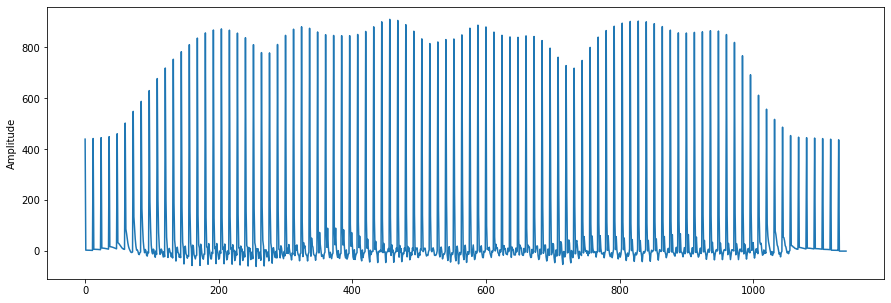

In [5]:
mfcc_flattened = np.reshape(mfcc.T, (mfcc.shape[0] * mfcc.shape[1]))
plt.figure(figsize = (15, 5))
plt.plot(mfcc_flattened)
plt.ylabel('Amplitude')

## Section-2

In [51]:
import os
emotions = ['Calm', 'Happy', 'Sad', 'Angry']
path = 'EmotionSpeech/'
training_file_names = []
training_emotion_labels = []
for i in range(0, len(emotions)):
    sub_path = path + 'Train/' + emotions[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_emotion_labels = [i] * len(sub_file_names)
    training_file_names += sub_file_names
    training_emotion_labels += sub_emotion_labels

In [52]:
import numpy as np
import librosa
from pydub import AudioSegment
from pydub.utils import mediainfo

def mfcc_extraction(audio_filename, #.wav filename
                    hop_duration, #hop_length in seconds, e.g., 0.015s (i.e., 15ms)
                    num_mfcc, #number of mfcc features
                    num_frames #number of frames
                   ):
    speech = AudioSegment.from_wav(audio_filename) #Read audio data from file
    samples = speech.get_array_of_samples() #samples x(t)
    sampling_rate = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    
    mfcc = librosa.feature.mfcc(
        np.float32(samples),
        sr = sampling_rate,
        hop_length = int(sampling_rate * hop_duration),
        n_mfcc = num_mfcc)
    
    mfcc_truncated = np.zeros((num_mfcc, num_frames), np.float32)
    for i in range(min(num_frames, mfcc.shape[1])):
        mfcc_truncated[:, i] = mfcc[:, i]
    
    #output is a vector including mfcc_truncated.shape[0] * mfcc_truncated.shape[1] elements
    return np.reshape(mfcc_truncated.T, mfcc_truncated.shape[0] * mfcc_truncated.shape[1])

Task-1

In [53]:
training_mfcc = []
for file_name in training_file_names:
    mfcc = mfcc_extraction(file_name, 0.015, 12, 200)
    training_mfcc.append(mfcc)

In [54]:
type(mfcc)

numpy.ndarray

In [11]:
test_file_names = []
test_emotion_labels = []

for i in range(0, len(emotions)):
    sub_path = path + 'Test/' + emotions[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_emotion_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    test_file_names += sub_file_names
    test_emotion_labels += sub_emotion_labels

In [43]:
from sklearn import svm
svm_classifier = svm.SVC(C = 50, #see slide 32 in week 4 lecture slides
                            kernel = 'linear') #see slide 35 in week 4 lecture slides
svm_classifier.fit(training_mfcc, training_emotion_labels)

SVC(C=50, kernel='linear')

Task-2 SVM

In [34]:
def get_predicted_labels(classifier, n_mfcc):
    predicted_emotion_labels = []
    for file_name in test_file_names:
        mfcc = mfcc_extraction(file_name, 0.015, n_mfcc, 200)
        predicted_emotion_label = classifier.predict([mfcc])
        predicted_emotion_labels.append(predicted_emotion_label)
    return predicted_emotion_labels

In [42]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
def get_classification_report(predicted_emotion_labels):    
    cm = confusion_matrix(test_emotion_labels, predicted_emotion_labels)
    print('Confusion Matrix', cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm.diagonal())
    
    acc = np.sum(cm.diagonal()) / np.sum(cm)
    print('Overall accuracy: {} %'.format(acc*100))
    
    print(classification_report(test_emotion_labels, predicted_emotion_labels))
    print('Accuracy Score', accuracy_score(test_emotion_labels, predicted_emotion_labels))

In [44]:
predicted_emotion_labels_svm = get_predicted_labels(svm_classifier, 12)
get_classification_report(predicted_emotion_labels_svm)

Confusion Matrix [[29  0  3  0]
 [ 4 12 14  2]
 [ 8  0 22  2]
 [ 4  7  3 18]]
[0.90625 0.375   0.6875  0.5625 ]
Overall accuracy: 63.28125 %
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        32
           1       0.63      0.38      0.47        32
           2       0.52      0.69      0.59        32
           3       0.82      0.56      0.67        32

    accuracy                           0.63       128
   macro avg       0.65      0.63      0.62       128
weighted avg       0.65      0.63      0.62       128

Accuracy Score 0.6328125


In [38]:
def train_svm_classifier(n_mfcc):
    training_mfcc = []
    for file_name in training_file_names:
        mfcc = mfcc_extraction(file_name, 0.015, n_mfcc, 200)
        training_mfcc.append(mfcc)
    
    svm_classifier = svm.SVC(C = 30, #see slide 32 in week 4 lecture slides
                            kernel = 'linear') #see slide 35 in week 4 lecture slides
    svm_classifier.fit(training_mfcc, training_emotion_labels)
    
    return svm_classifier

In [47]:
num_mfccs = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

for n_mfcc in num_mfccs:
    print('Value of num_mfcc is', n_mfcc)
    svm_classifier = train_svm_classifier(n_mfcc)
    predicted_emotion_labels_svm = get_predicted_labels(svm_classifier, n_mfcc)
    get_classification_report(predicted_emotion_labels_svm)

Value of num_mfcc is 12
Confusion Matrix [[29  0  3  0]
 [ 4 12 14  2]
 [ 8  0 22  2]
 [ 4  7  3 18]]
[0.90625 0.375   0.6875  0.5625 ]
Overall accuracy: 63.28125 %
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        32
           1       0.63      0.38      0.47        32
           2       0.52      0.69      0.59        32
           3       0.82      0.56      0.67        32

    accuracy                           0.63       128
   macro avg       0.65      0.63      0.62       128
weighted avg       0.65      0.63      0.62       128

Accuracy Score 0.6328125
Value of num_mfcc is 14
Confusion Matrix [[29  0  3  0]
 [ 4 12 14  2]
 [ 8  0 22  2]
 [ 4  7  3 18]]
[0.90625 0.375   0.6875  0.5625 ]
Overall accuracy: 63.28125 %
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        32
           1       0.63      0.38      0.47        32
           2       0.52      0.69      0.59    

Task-3 AdaBoost Classifier

In [49]:
from sklearn.ensemble import AdaBoostClassifier

def train_adaboost_classifier(n_mfcc):
    training_mfcc = []
    for file_name in training_file_names:
        mfcc = mfcc_extraction(file_name, 0.015, n_mfcc, 200)
        training_mfcc.append(mfcc)
    
    adb_classifier = AdaBoostClassifier(n_estimators = 150,
                                        random_state = 0)
    
    adb_classifier.fit(training_mfcc, training_emotion_labels)
    
    return adb_classifier

In [50]:
num_mfccs = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

for n_mfcc in num_mfccs:
    print('Value of num_mfcc is', n_mfcc)
    adb_classifier = train_adaboost_classifier(n_mfcc)
    predicted_emotion_labels_ada = get_predicted_labels(adb_classifier, n_mfcc)
    get_classification_report(predicted_emotion_labels_ada)

Value of num_mfcc is 12
Confusion Matrix [[30  0  2  0]
 [13  0  9 10]
 [24  0  3  5]
 [ 4  0  8 20]]
[0.9375  0.      0.09375 0.625  ]
Overall accuracy: 41.40625 %
              precision    recall  f1-score   support

           0       0.42      0.94      0.58        32
           1       0.00      0.00      0.00        32
           2       0.14      0.09      0.11        32
           3       0.57      0.62      0.60        32

    accuracy                           0.41       128
   macro avg       0.28      0.41      0.32       128
weighted avg       0.28      0.41      0.32       128

Accuracy Score 0.4140625
Value of num_mfcc is 14


c:\program files\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix [[31  0  1  0]
 [14  1 10  7]
 [24  2  3  3]
 [ 2  4 10 16]]
[0.96875 0.03125 0.09375 0.5    ]
Overall accuracy: 39.84375 %
              precision    recall  f1-score   support

           0       0.44      0.97      0.60        32
           1       0.14      0.03      0.05        32
           2       0.12      0.09      0.11        32
           3       0.62      0.50      0.55        32

    accuracy                           0.40       128
   macro avg       0.33      0.40      0.33       128
weighted avg       0.33      0.40      0.33       128

Accuracy Score 0.3984375
Value of num_mfcc is 16
Confusion Matrix [[28  0  4  0]
 [ 2  2 13 15]
 [19  1  9  3]
 [ 0  1  9 22]]
[0.875   0.0625  0.28125 0.6875 ]
Overall accuracy: 47.65625 %
              precision    recall  f1-score   support

           0       0.57      0.88      0.69        32
           1       0.50      0.06      0.11        32
           2       0.26      0.28      0.27        32
           3     